In [125]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from imblearn.over_sampling import SMOTE

In [126]:
dataset_path = "/content/drive/MyDrive/Colab Notebooks/bengkod/UASbengkod/ObesityDataSet.csv"
df = pd.read_csv(dataset_path)
df_clean = df.copy()

print("Lima baris pertama:\n", df.head())

Lima baris pertama:
   Age  Gender Height Weight        CALC FAVC FCVC NCP  SCC SMOKE CH2O  \
0  21  Female   1.62     64          no   no    2   3   no    no    2   
1  21  Female   1.52     56   Sometimes   no    3   3  yes   yes    3   
2  23    Male    1.8     77  Frequently   no    2   3   no    no    2   
3  27    Male    1.8     87  Frequently   no    3   3   no    no    2   
4  22    Male   1.78   89.8   Sometimes   no    2   1   no    no    2   

  family_history_with_overweight FAF TUE       CAEC                 MTRANS  \
0                            yes   0   1  Sometimes  Public_Transportation   
1                            yes   3   0  Sometimes  Public_Transportation   
2                            yes   2   1  Sometimes  Public_Transportation   
3                             no   2   0  Sometimes                Walking   
4                             no   0   0  Sometimes  Public_Transportation   

            NObeyesdad  
0        Normal_Weight  
1        Normal_Weigh

In [127]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [128]:
print("\nInformasi dataset:")
print(df.info())


Informasi dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Age                             2097 non-null   object
 1   Gender                          2102 non-null   object
 2   Height                          2099 non-null   object
 3   Weight                          2100 non-null   object
 4   CALC                            2106 non-null   object
 5   FAVC                            2100 non-null   object
 6   FCVC                            2103 non-null   object
 7   NCP                             2099 non-null   object
 8   SCC                             2101 non-null   object
 9   SMOKE                           2106 non-null   object
 10  CH2O                            2105 non-null   object
 11  family_history_with_overweight  2098 non-null   object
 12  FAF                         

In [129]:
print("\nDeskripsi statistik:\n", df.describe())


Deskripsi statistik:
          Age Gender Height Weight       CALC  FAVC  FCVC   NCP   SCC SMOKE  \
count   2097   2102   2099   2100       2106  2100  2103  2099  2101  2106   
unique  1394      3   1562   1518          5     3   808   637     3     3   
top       18   Male    1.7     80  Sometimes   yes     3     3    no    no   
freq     124   1056     58     58       1386  1844   647  1183  1997  2054   

        CH2O family_history_with_overweight   FAF   TUE       CAEC  \
count   2105                           2098  2103  2102       2100   
unique  1263                              3  1186  1130          5   
top        2                            yes     0     0  Sometimes   
freq     441                           1705   404   552       1747   

                       MTRANS      NObeyesdad  
count                    2105            2111  
unique                      6               7  
top     Public_Transportation  Obesity_Type_I  
freq                     1572             3

In [130]:
print("\nMissing values tiap kolom:\n", df.isnull().sum())
print("\nJumlah data duplikat:", df.duplicated().sum())


Missing values tiap kolom:
 Age                               14
Gender                             9
Height                            12
Weight                            11
CALC                               5
FAVC                              11
FCVC                               8
NCP                               12
SCC                               10
SMOKE                              5
CH2O                               6
family_history_with_overweight    13
FAF                                8
TUE                                9
CAEC                              11
MTRANS                             6
NObeyesdad                         0
dtype: int64

Jumlah data duplikat: 18


In [131]:
print("\nJumlah nilai unik tiap kolom:\n", df.nunique())


Jumlah nilai unik tiap kolom:
 Age                               1394
Gender                               3
Height                            1562
Weight                            1518
CALC                                 5
FAVC                                 3
FCVC                               808
NCP                                637
SCC                                  3
SMOKE                                3
CH2O                              1263
family_history_with_overweight       3
FAF                               1186
TUE                               1130
CAEC                                 5
MTRANS                               6
NObeyesdad                           7
dtype: int64


In [132]:
# Cek nilai unik dan missing values
print("Missing Values:")
print(df.isnull().sum())
print("Unique Values:")
print(df.nunique())
print("Checking '?' values:")
print((df == "?").sum())

Missing Values:
Age                               14
Gender                             9
Height                            12
Weight                            11
CALC                               5
FAVC                              11
FCVC                               8
NCP                               12
SCC                               10
SMOKE                              5
CH2O                               6
family_history_with_overweight    13
FAF                                8
TUE                                9
CAEC                              11
MTRANS                             6
NObeyesdad                         0
dtype: int64
Unique Values:
Age                               1394
Gender                               3
Height                            1562
Weight                            1518
CALC                                 5
FAVC                                 3
FCVC                               808
NCP                                637
SCC            

In [133]:
# Define the list of numerical columns
numerical_cols = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

# Replace '?' with NaN in the entire dataframe
df.replace('?', float('nan'), inplace=True)

# Convert columns to numeric, coercing errors to NaN
df[numerical_cols] = df[numerical_cols].apply(pd.to_numeric, errors='coerce')

# Handle missing values by filling NaNs with the mean of each column
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].mean())

# Fungsi untuk menghapus outlier dengan metode IQR
def drop_outliers_iqr(df, cols):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Terapkan fungsi penghapusan outlier
df = drop_outliers_iqr(df, numerical_cols)


# Now, apply scaling
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])


In [134]:
print("Missing Values:")
print(df.isnull().sum())
print("Unique Values:")
print(df.nunique())
print("Checking '?' values:")
print((df == "?").sum())

Missing Values:
Age                                0
Gender                            15
Height                             0
Weight                             0
CALC                              14
FAVC                              15
FCVC                               0
NCP                                0
SCC                               13
SMOKE                              8
CH2O                               0
family_history_with_overweight    15
FAF                                0
TUE                                0
CAEC                              11
MTRANS                             8
NObeyesdad                         0
dtype: int64
Unique Values:
Age                                883
Gender                               2
Height                            1040
Weight                            1031
CALC                                 3
FAVC                                 2
FCVC                               476
NCP                                255
SCC            

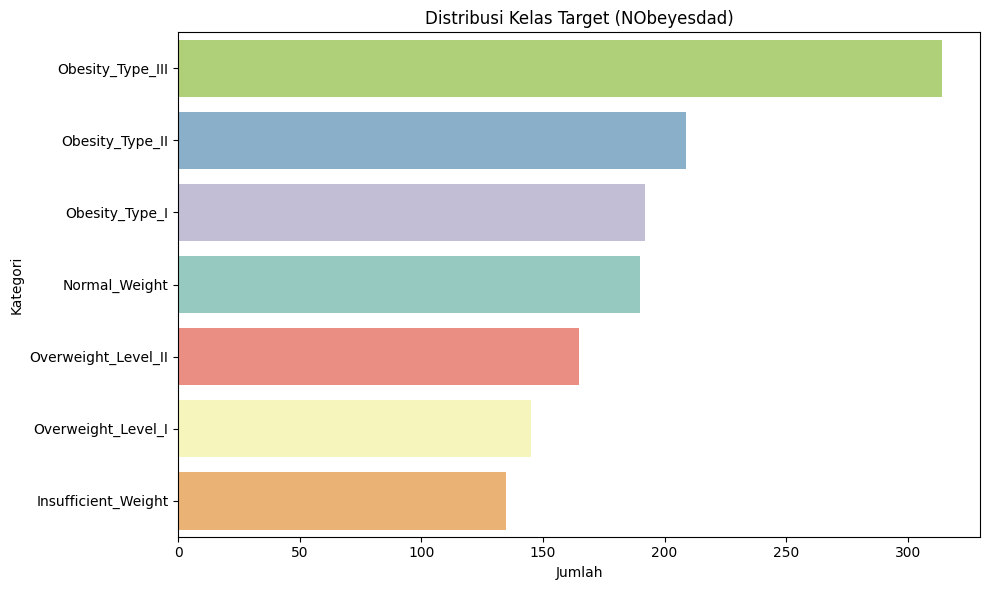

In [135]:
# Visualisasi distribusi kelas target
plt.figure(figsize=(10, 6))
sns.countplot(y='NObeyesdad', data=df, order=df['NObeyesdad'].value_counts().index, palette='Set3', hue='NObeyesdad', legend=False)
plt.title('Distribusi Kelas Target (NObeyesdad)')
plt.xlabel('Jumlah')
plt.ylabel('Kategori')
plt.tight_layout()
plt.show()

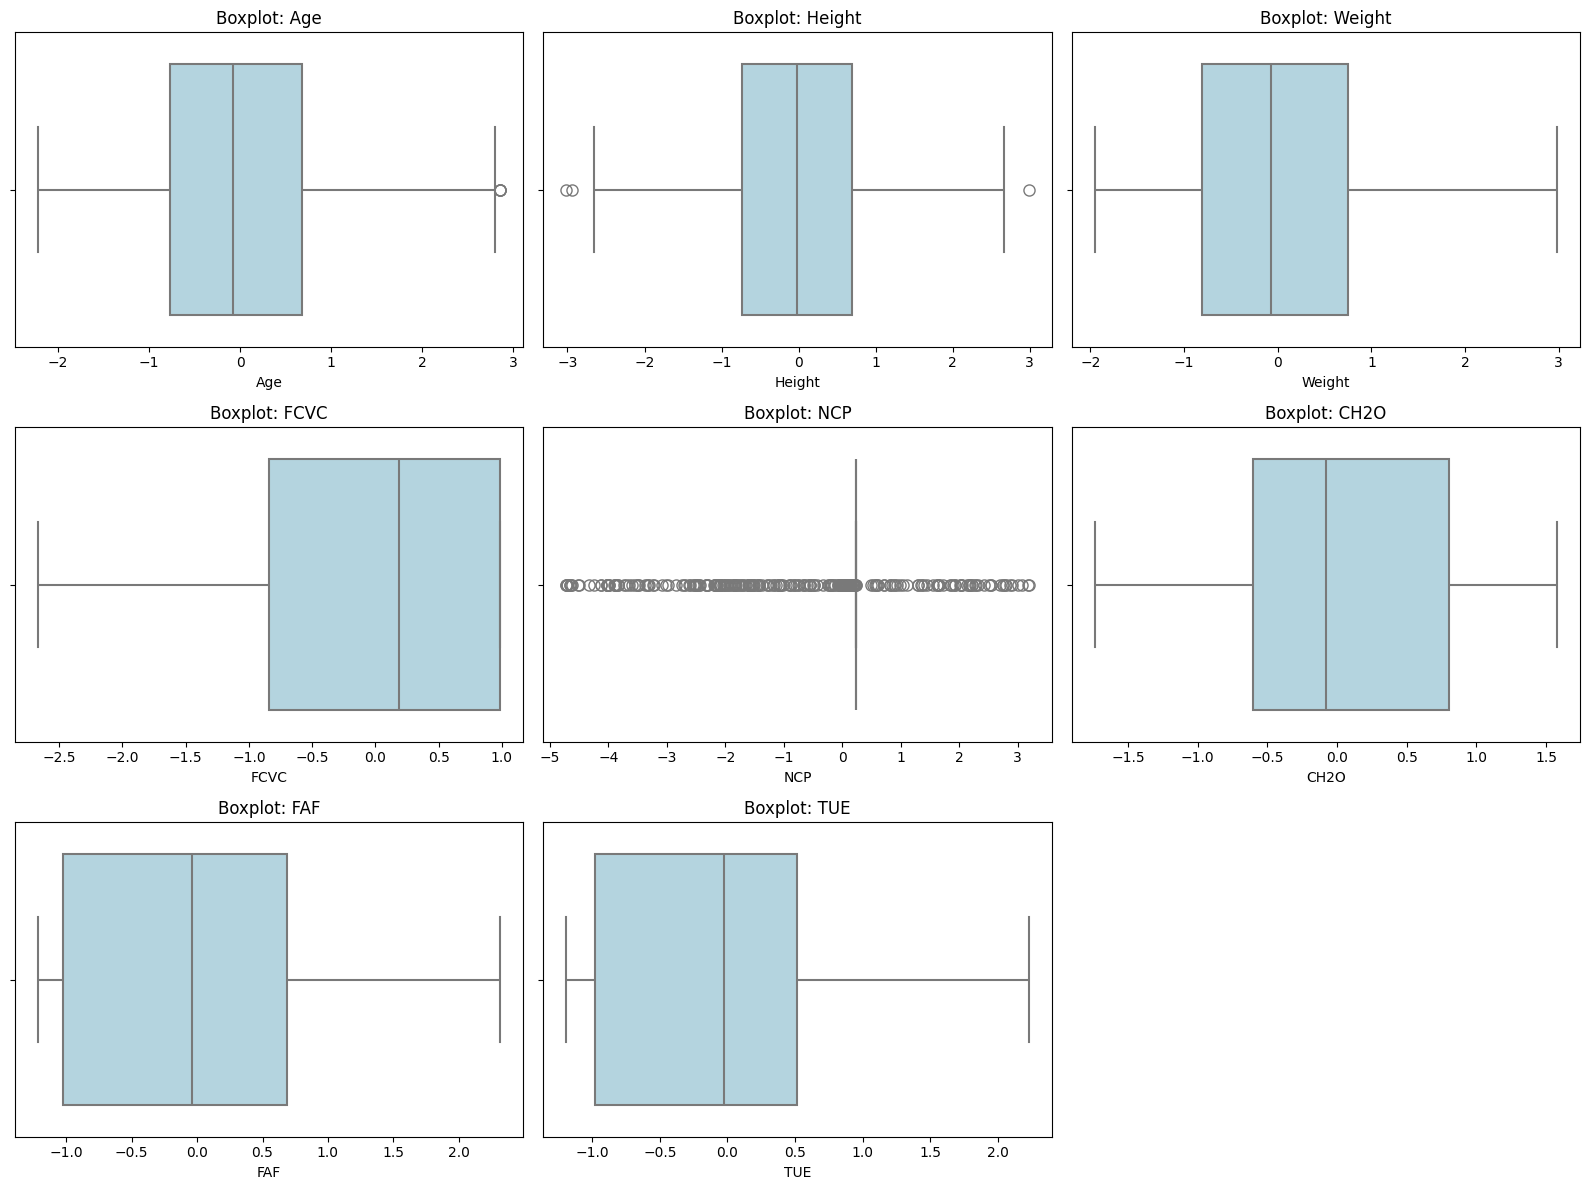

In [136]:
# Visualize Boxplot for Outliers
plt.figure(figsize=(16, 12))
for i, col in enumerate(numerical_cols):
    plt.subplot(3, 3, i+1)  # Arrange boxplots in a 3x3 grid
    sns.boxplot(x=col, data=df, color='lightblue', fliersize=8, linewidth=1.5)  # Increase fliersize for better visibility
    plt.title(f'Boxplot: {col}')
    plt.xlabel(col)

plt.tight_layout()
plt.show()

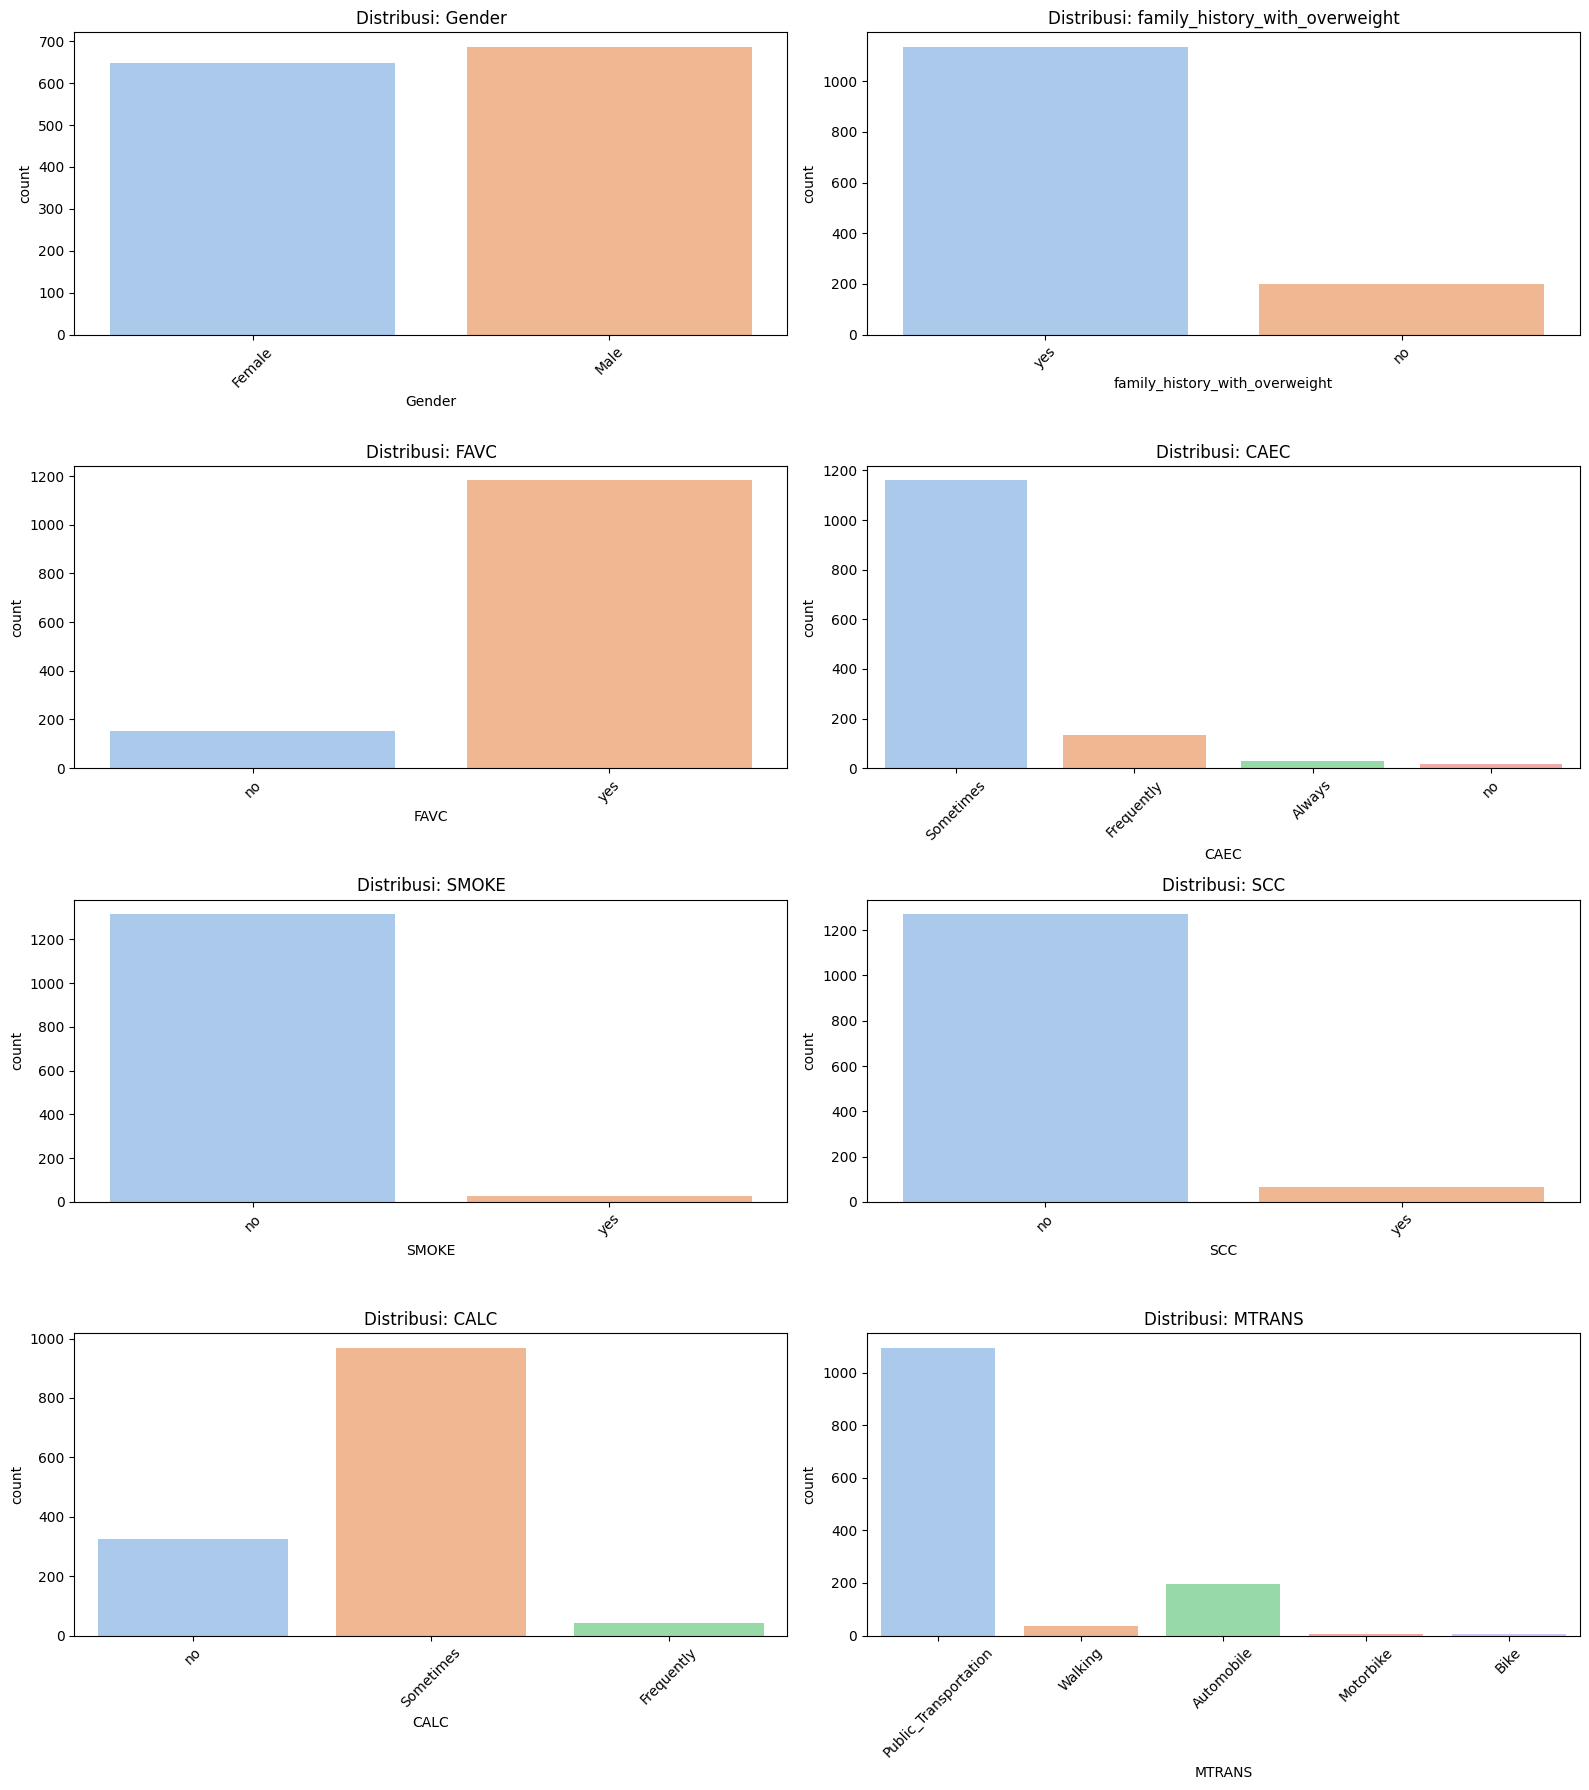

In [137]:
# Visualisasi kolom kategorikal dan biner
categorical_cols = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE',
                    'SCC', 'CALC', 'MTRANS']

plt.figure(figsize=(16, 18))
for i, col in enumerate(categorical_cols):
    plt.subplot(4, 2, i+1)
    sns.countplot(data=df, x=col, hue=col, palette='pastel', legend=False)
    plt.title(f'Distribusi: {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [138]:
# Gantilah data yang tidak valid dengan NaN
df.replace('?', float('nan'), inplace=True)

# Cek data yang tidak valid (contoh: nilai negatif untuk kolom umur atau tinggi badan)
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')
df['Height'] = pd.to_numeric(df['Height'], errors='coerce')

# Cek untuk nilai negatif
invalid_data = df[(df['Age'] < 0) | (df['Height'] < 0)]
print("Data invalid:")
print(invalid_data)


Data invalid:
           Age  Gender    Height    Weight        CALC FAVC      FCVC  \
0    -0.526976  Female -1.074779 -1.034353          no   no -0.839935   
1    -0.526976  Female -2.216168 -1.329062   Sometimes   no  0.986875   
2    -0.043822    Male  0.979722 -0.555451  Frequently   no -0.839935   
5     1.405638    Male -1.074779 -1.439578   Sometimes  yes -0.839935   
6    -0.043822  Female -2.444446 -1.365900   Sometimes  yes  0.986875   
...        ...     ...       ...       ...         ...  ...       ...   
2104 -0.362132  Female  0.207949  1.509131   Sometimes  yes  0.986875   
2105 -0.457893  Female  0.145595  1.446205   Sometimes  yes  0.986875   
2106 -0.532570  Female -0.039196  1.448885   Sometimes  yes  0.986875   
2107 -0.289520  Female  0.392865  1.534881   Sometimes  yes  0.986875   
2108 -0.158804  Female  0.434206  1.532907   Sometimes  yes  0.986875   

           NCP  SCC SMOKE      CH2O family_history_with_overweight       FAF  \
0     0.232484   no    no -0.

In [139]:
# Cek duplikasi
duplicates = df.duplicated().sum()
print(f"Jumlah data duplikat: {duplicates}")

# Hapus duplikasi jika ada
df.drop_duplicates(inplace=True)

Jumlah data duplikat: 1


In [140]:
# Label Encoding untuk kolom kategorikal
categorical_cols = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']

label_encoder = LabelEncoder()
for col in categorical_cols:
    df[col] = label_encoder.fit_transform(df[col])

print(df[categorical_cols].head())


   Gender  family_history_with_overweight  FAVC  CAEC  SMOKE  SCC  CALC  \
0       0                               1     0     2      0    0     2   
1       0                               1     0     2      1    1     1   
2       1                               1     0     2      0    0     0   
3       1                               0     0     2      0    0     0   
5       1                               0     1     2      0    0     1   

   MTRANS  
0       3  
1       3  
2       3  
3       4  
5       0  


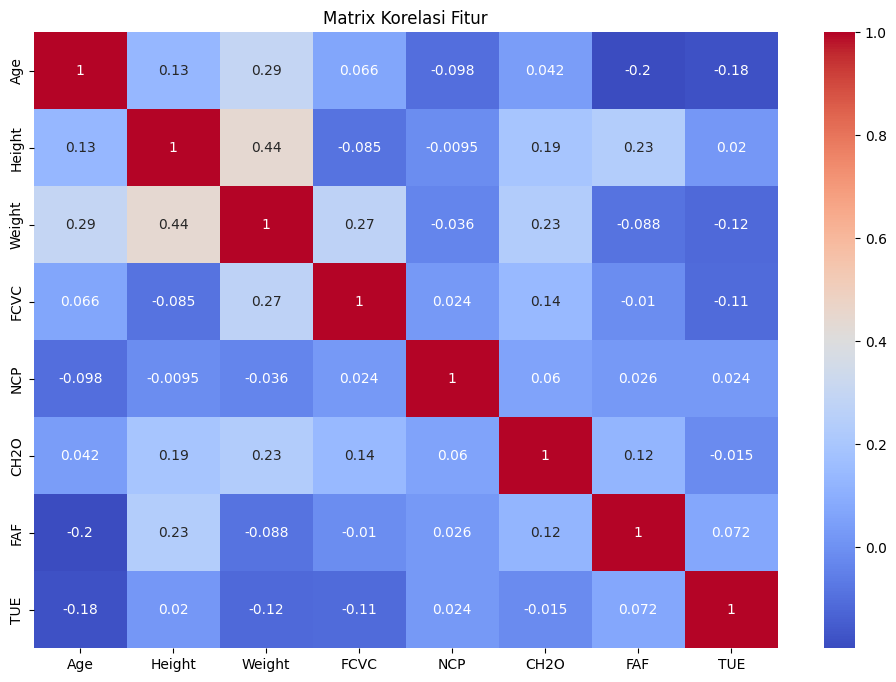

In [141]:
# Compute the correlation matrix
numerical_cols = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE'] # Ensure numerical_cols is defined or use the one from previous cells
correlation_matrix = df[numerical_cols].corr()

# Visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matrix Korelasi Fitur')
plt.show()


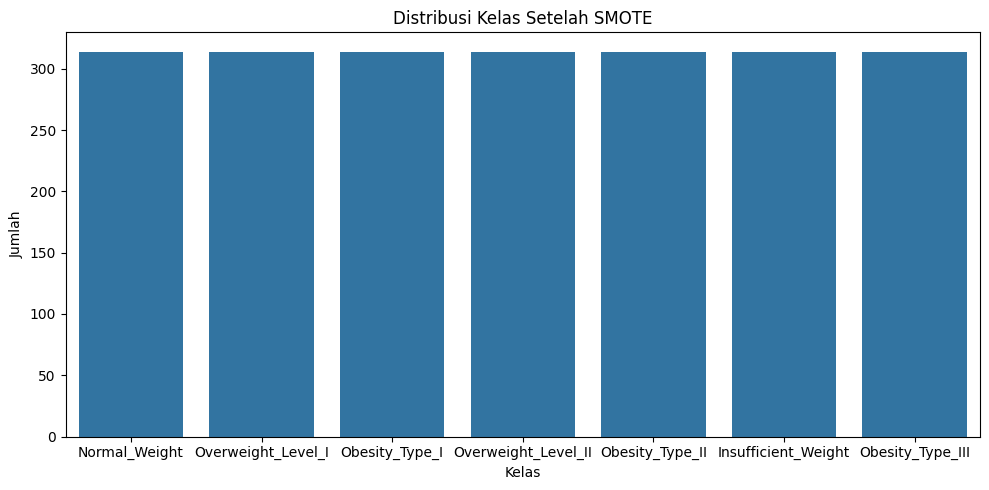

In [142]:
# Pisahkan fitur dan target
X = df.drop(columns=['NObeyesdad'])
y = df['NObeyesdad']

# Terapkan SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Visualisasi distribusi kelas setelah SMOTE
plt.figure(figsize=(10, 5))  # Mengatur ukuran gambar untuk memberi ruang yang cukup
sns.countplot(x=y_resampled)
plt.title('Distribusi Kelas Setelah SMOTE')
plt.xlabel('Kelas')
plt.ylabel('Jumlah')
plt.tight_layout()  # Mengatur layout agar tidak tumpang tindih
plt.show()

In [143]:
# Standarisasi data numerik
scaler = StandardScaler()
X_resampled[numerical_cols] = scaler.fit_transform(X_resampled[numerical_cols])

# Cek data setelah standarisasi
X_resampled[numerical_cols].head()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
0,-0.455365,-1.090451,-0.859829,-0.758992,0.217356,-0.034842,-1.298390,0.464252
1,-0.455365,-2.246078,-1.164838,1.106054,0.217356,1.670773,2.308535,-1.218527
2,0.016029,0.989677,-0.364188,-0.758992,0.217356,-0.034842,1.106226,0.464252
3,0.958817,0.989677,0.017074,1.106054,0.217356,-0.034842,1.106226,-1.218527
4,1.430211,-1.090451,-1.279217,-0.758992,0.217356,-0.034842,-1.298390,-1.218527


In [144]:
# Mengecek jumlah missing values per kolom
print(df.isnull().sum())

Age                               0
Gender                            0
Height                            0
Weight                            0
CALC                              0
FAVC                              0
FCVC                              0
NCP                               0
SCC                               0
SMOKE                             0
CH2O                              0
family_history_with_overweight    0
FAF                               0
TUE                               0
CAEC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64


In [145]:
# Mengecek jumlah duplikasi dalam dataset
print(df.duplicated().sum())

0


In [146]:
# Mengecek jumlah kemunculan '?' pada dataset
print((df == "?").sum())

Age                               0
Gender                            0
Height                            0
Weight                            0
CALC                              0
FAVC                              0
FCVC                              0
NCP                               0
SCC                               0
SMOKE                             0
CH2O                              0
family_history_with_overweight    0
FAF                               0
TUE                               0
CAEC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64


In [148]:
# Ganti nilai yang tidak valid pada kolom 'Age' (misal -1) dengan NaN
df['Age'] = df['Age'].replace(-1, np.nan)

# Mengganti nilai yang tidak valid pada kolom 'Gender' jika ada
df['Gender'] = df['Gender'].replace([3, 4], np.nan)  # Misalnya 3 dan 4 adalah kategori yang tidak valid

# Gantilah dengan imputasi (misal menggunakan median untuk 'Age' atau modus untuk 'Gender')
df['Age'] = df['Age'].fillna(df['Age'].median())
df['Gender'] = df['Gender'].fillna(df['Gender'].mode()[0])


In [149]:
# Ganti nilai yang tidak valid pada kolom 'SMOKE' dan 'MTRANS' dengan NaN jika ada
df['SMOKE'] = df['SMOKE'].replace([3, 4], np.nan)  # Anggap 3 dan 4 adalah nilai yang tidak valid di kolom SMOKE
df['MTRANS'] = df['MTRANS'].replace([6, 7], np.nan)  # Anggap 6 dan 7 adalah nilai yang tidak valid di kolom MTRANS

# Imputasi nilai yang hilang (misalnya menggunakan modus atau nilai yang sering muncul)
df['SMOKE'] = df['SMOKE'].fillna(df['SMOKE'].mode()[0])
df['MTRANS'] = df['MTRANS'].fillna(df['MTRANS'].mode()[0])


In [150]:
# Pisah fitur dan target
X = df.drop("NObeyesdad", axis=1)
y = df["NObeyesdad"]

# Normalisasi
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

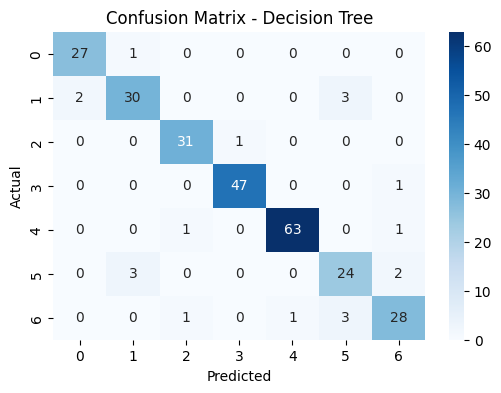

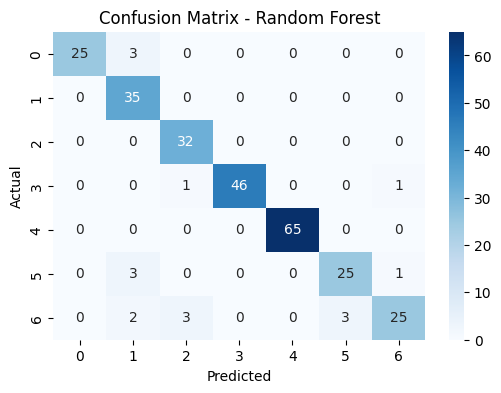

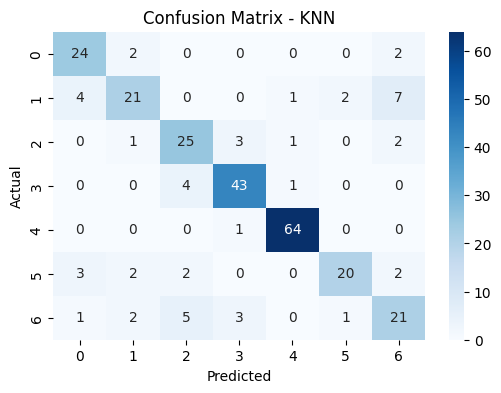

In [151]:
#Pemodelan
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "KNN": KNeighborsClassifier()
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1
    })

 # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

<Figure size 1000x600 with 0 Axes>

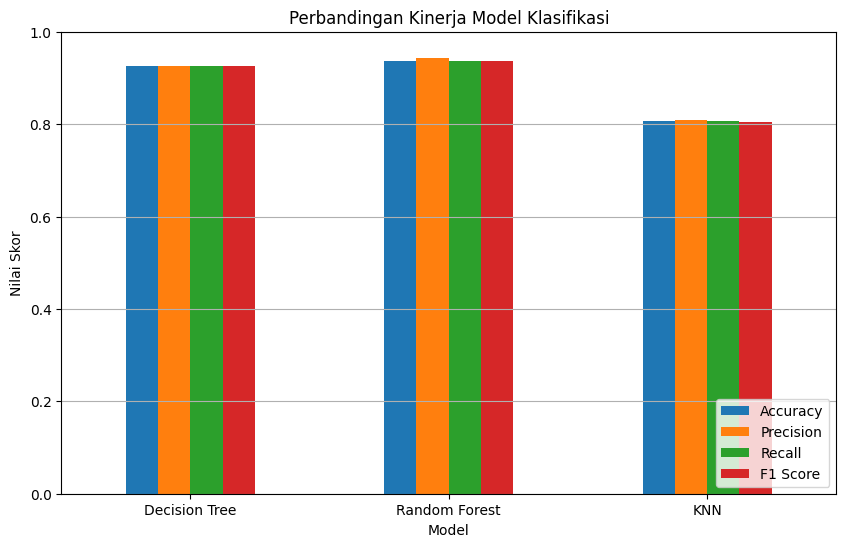

In [152]:
#Visualisasi Perbandingan Hasil
df_result = pd.DataFrame(results)
df_result.set_index("Model", inplace=True)

plt.figure(figsize=(10,6))
df_result.plot(kind='bar', figsize=(10,6))
plt.title("Perbandingan Kinerja Model Klasifikasi")
plt.ylabel("Nilai Skor")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.legend(loc='lower right')
plt.show()

In [153]:
#Laporan Lengkap
print("\n--- Laporan Evaluasi Lengkap ---\n")
for name, model in models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Classification Report (Akurasi: {acc:.2f}):\n")
    print(classification_report(y_test, y_pred))
    print("="*60)


--- Laporan Evaluasi Lengkap ---

Decision Tree Classification Report (Akurasi: 0.93):

                     precision    recall  f1-score   support

Insufficient_Weight       0.93      0.96      0.95        28
      Normal_Weight       0.88      0.86      0.87        35
     Obesity_Type_I       0.94      0.97      0.95        32
    Obesity_Type_II       0.98      0.98      0.98        48
   Obesity_Type_III       0.98      0.97      0.98        65
 Overweight_Level_I       0.80      0.83      0.81        29
Overweight_Level_II       0.88      0.85      0.86        33

           accuracy                           0.93       270
          macro avg       0.91      0.92      0.91       270
       weighted avg       0.93      0.93      0.93       270

Random Forest Classification Report (Akurasi: 0.94):

                     precision    recall  f1-score   support

Insufficient_Weight       1.00      0.89      0.94        28
      Normal_Weight       0.81      1.00      0.90        35

In [154]:
# Param grid untuk setiap mode
param_grid = {
    "Decision Tree": {
        "max_depth": [3, 5, 10, None],
        "criterion": ["gini", "entropy"]
    },
    "Random Forest": {
        "n_estimators": [50, 100, 150],
        "max_depth": [None, 10, 20],
        "criterion": ["gini", "entropy"]
    },
    "KNN": {
        "n_neighbors": [3, 5, 7, 9],
        "weights": ["uniform", "distance"]
    }
}

# Dictionary model asli (tanpa tuning)
base_models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "KNN": KNeighborsClassifier()
}

# Simpan hasil awal dan setelah tuning
before_tuning = []
after_tuning = []

In [155]:
# Proses GridSearchCV dan evaluasi
for name, model in base_models.items():
    print(f"Tuning {name}...")
    grid = GridSearchCV(model, param_grid[name], cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)

    # Sebelum tuning (pakai model asli)
    model.fit(X_train, y_train)
    y_pred_before = model.predict(X_test)
    acc_before = accuracy_score(y_test, y_pred_before)
    f1_before = f1_score(y_test, y_pred_before, average='weighted')
    before_tuning.append({
        "Model": name,
        "Accuracy": acc_before,
        "F1 Score": f1_before
    })

    # Setelah tuning
    best_model = grid.best_estimator_
    best_model.fit(X_train, y_train)
    y_pred_after = best_model.predict(X_test)
    acc_after = accuracy_score(y_test, y_pred_after)
    f1_after = f1_score(y_test, y_pred_after, average='weighted')
    after_tuning.append({
        "Model": name,
        "Accuracy": acc_after,
        "F1 Score": f1_after
    })

    print(f"Best Params for {name}: {grid.best_params_}")
    print(f"Accuracy Before: {acc_before:.4f}, After: {acc_after:.4f}")
    print("="*50)

Tuning Decision Tree...
Best Params for Decision Tree: {'criterion': 'gini', 'max_depth': None}
Accuracy Before: 0.9259, After: 0.9259
Tuning Random Forest...
Best Params for Random Forest: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 100}
Accuracy Before: 0.9370, After: 0.9481
Tuning KNN...
Best Params for KNN: {'n_neighbors': 3, 'weights': 'distance'}
Accuracy Before: 0.8074, After: 0.8444


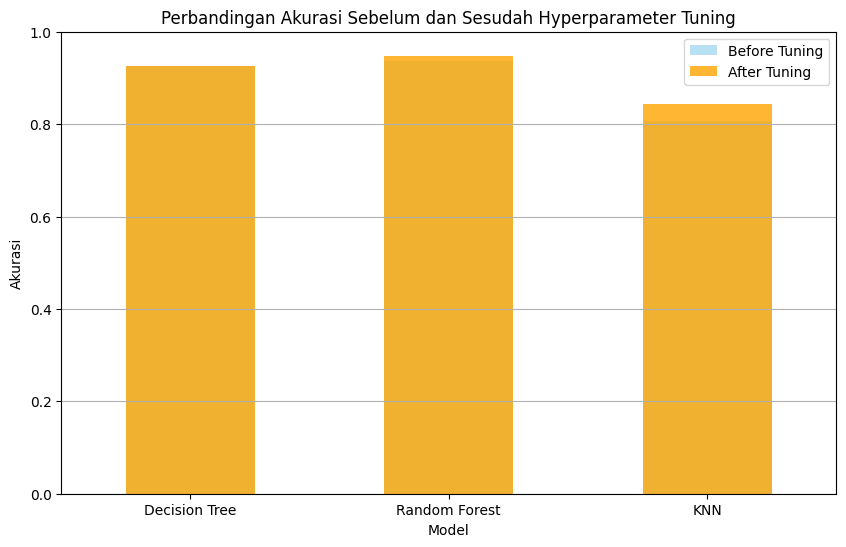

In [156]:
# --- Visualisasi Perbandingan Sebelum & Sesudah Tuning ---
df_before = pd.DataFrame(before_tuning).set_index("Model")
df_after = pd.DataFrame(after_tuning).set_index("Model")

plt.figure(figsize=(10,6))
df_before["Accuracy"].plot(kind='bar', alpha=0.6, label='Before Tuning', color='skyblue')
df_after["Accuracy"].plot(kind='bar', alpha=0.8, label='After Tuning', color='orange')
plt.title("Perbandingan Akurasi Sebelum dan Sesudah Hyperparameter Tuning")
plt.ylabel("Akurasi")
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y')
plt.xticks(rotation=0)
plt.show()

In [157]:
# Ringkasan
print("\nRingkasan Evaluasi Hyperparameter Tuning \n")
summary = pd.DataFrame({
    "Model": df_before.index,
    "Accuracy Before": df_before["Accuracy"].values,
    "Accuracy After": df_after["Accuracy"].values,
    "F1 Score Before": df_before["F1 Score"].values,
    "F1 Score After": df_after["F1 Score"].values,
})
print(summary)


Ringkasan Evaluasi Hyperparameter Tuning 

           Model  Accuracy Before  Accuracy After  F1 Score Before  \
0  Decision Tree         0.925926        0.925926         0.925913   
1  Random Forest         0.937037        0.948148         0.936520   
2            KNN         0.807407        0.844444         0.805221   

   F1 Score After  
0        0.925913  
1        0.947784  
2        0.844051  


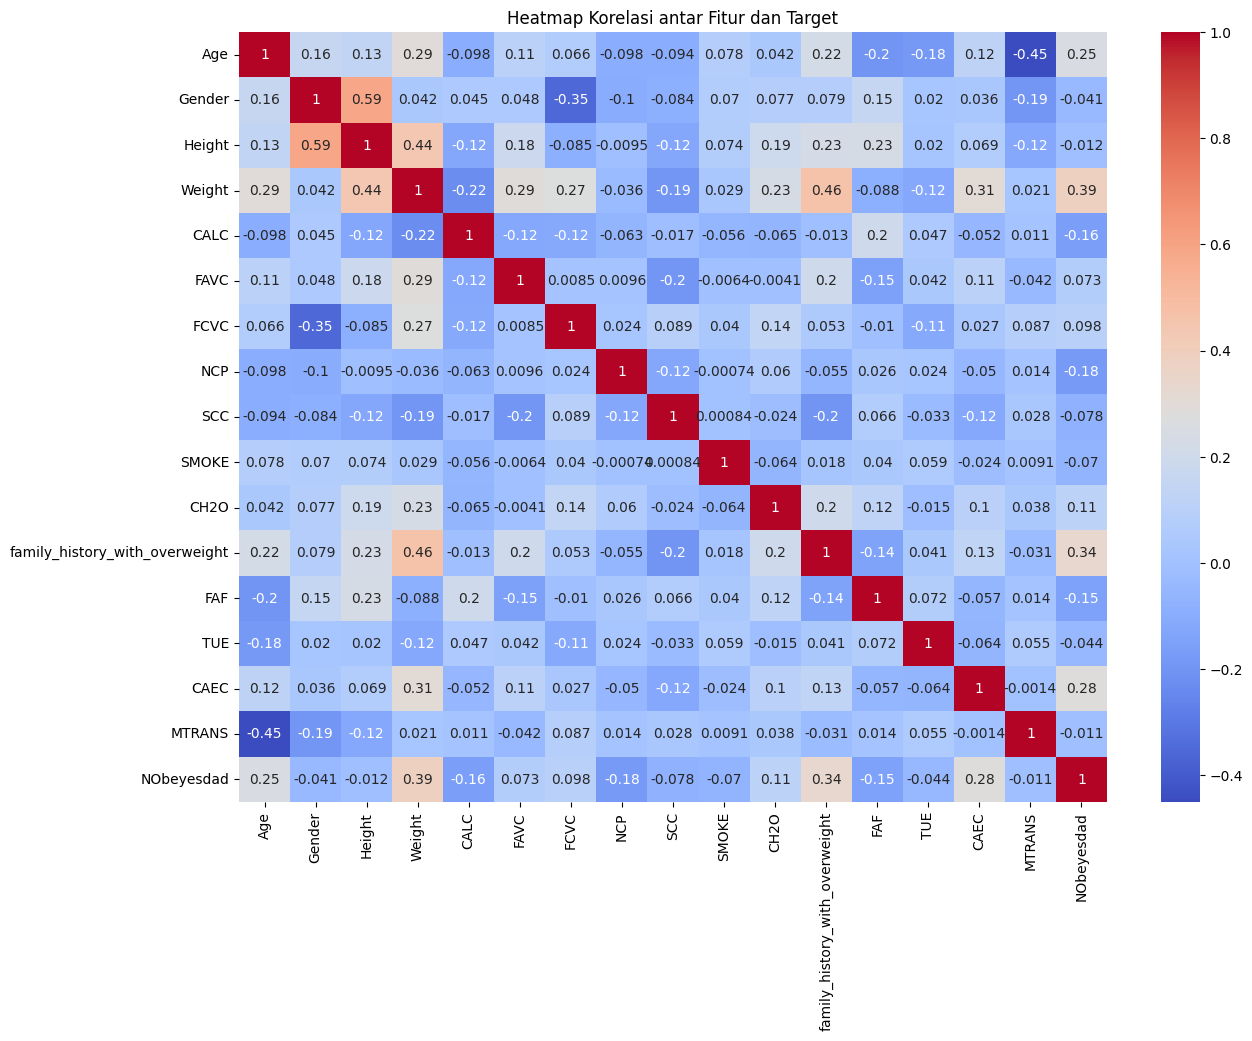

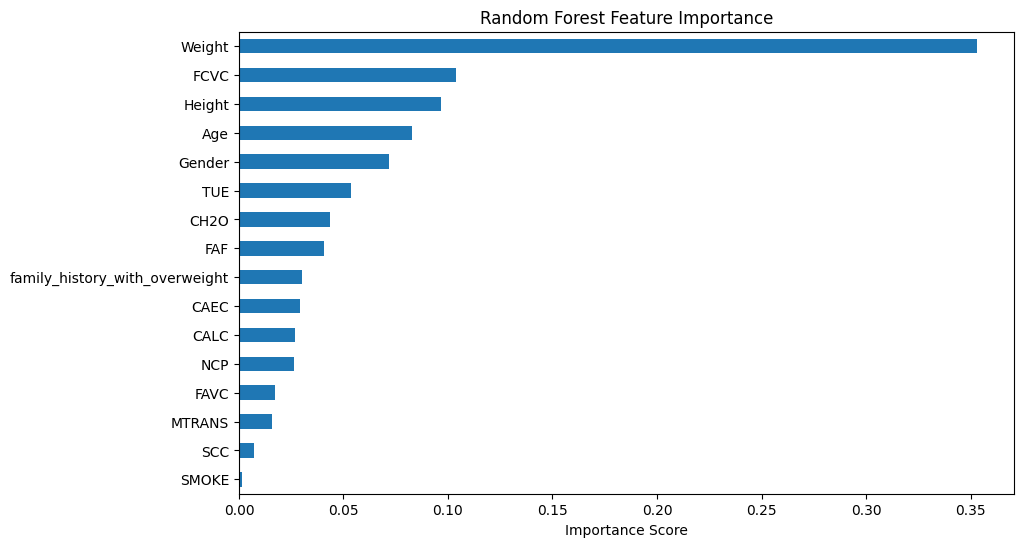

In [158]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Salin dataframe agar tidak merusak yang asli
df_corr = df.copy()

# Encode kolom target menjadi angka
df_corr['NObeyesdad'] = LabelEncoder().fit_transform(df_corr['NObeyesdad'])

# Hitung korelasi dan tampilkan heatmap
plt.figure(figsize=(14,10))
corr = df_corr.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Heatmap Korelasi antar Fitur dan Target")
plt.show()

# Pisahkan fitur dan target
X = df.drop("NObeyesdad", axis=1)
y = df["NObeyesdad"]

# Hitung feature importance dengan Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

importances = pd.Series(rf.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

# Visualisasi feature importance
plt.figure(figsize=(10,6))
importances.plot(kind='barh')
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance Score")
plt.gca().invert_yaxis()
plt.show()

In [159]:
#import pickle

# Asumsikan model final hasil hypertuning: rf_best
# Dan scaler hasil fit: scaler

#with open("model_rf.pkl", "wb") as f:
    #pickle.dump(rf, f)  # atau rf_best jika hypertuning pakai GridSearchCV

#with open("scaler.pkl", "wb") as f:
    #pickle.dump(scaler, f)


In [160]:
#from google.colab import files
#3files.download("model_rf.pkl")
#files.download("scaler.pkl")
